# 첫 번째 합성곱 신경망

# 라이브러리 임포트

In [1]:
import numpy as np

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 데이터 적재

In [3]:
NUM_CLASSES = 10

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
y_train.shape

(50000, 10)

# 모델 만들기

## model #1

In [11]:
input_layer = Input(shape=(32,32,3))

conv_layer_1 = Conv2D(
    filters = 10
    , kernel_size = (4,4)
    , strides = 2
    , padding = 'same'
    )(input_layer)

conv_layer_2 = Conv2D(
    filters = 20
    , kernel_size = (3,3)
    , strides = 2
    , padding = 'same'
    )(conv_layer_1)

flatten_layer = Flatten()(conv_layer_2)

output_layer = Dense(units=10, activation = 'softmax')(flatten_layer)

model = Model(input_layer, output_layer)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 10)        490       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 20)          1820      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                12810     
Total params: 15,120
Trainable params: 15,120
Non-trainable params: 0
_________________________________________________________________


### Model Evaluation

In [19]:
# model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 0s 46us/step


[1.7175160646438599, 0.4150999993085861]

## model #2

In [25]:
input_layer = Input((32,32,3))

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 32)        0         
__________

### Model Evaluation

In [30]:
# model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 6s 577us/step


[0.8161628365516662, 0.7222000002861023]

## manual VGG16

In [8]:
input_layer = Input((32,32,3))

## https://github.com/mjiansun/cifar10-vgg16/blob/master/vgg.py

# Block 1
x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(input_layer)
x = Conv2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
x = Conv2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
x = Conv2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
x = Conv2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

model = Model(input_layer, output_layer, name='vgg16')

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  
/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  import sys
/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/envs/GDL/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  if sys.path[0] == '':
/usr/local/anaconda3/e

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [10]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data = (x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1967s 39ms/step - loss: 2.3029 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/10
50000/50000 [==============================] - 1954s 39ms/step - loss: 2.3027 - acc: 0.0960 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 1931s 39ms/step - loss: 2.3027 - acc: 0.0980 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 1927s 39ms/step - loss: 2.3027 - acc: 0.0956 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 1928s 39ms/step - loss: 2.3027 - acc: 0.0982 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 1930s 39ms/step - loss: 2.3027 - acc: 0.0981 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 1929

### Model Evaluation

In [ ]:
model.evaluate(x_test, y_test, batch_size=1000)

In [ ]:
!git add -A
!git commit -m "manual VGG16 done"
!git push

### Comparing with original VGG16 of keras

In [18]:
# model = VGG16(weights='imagenet', include_top=False)
model = VGG16(include_top=False, input_shape=(32,32,3), classes=NUM_CLASSES)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [19]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data = (x_test, y_test))

ValueError: Error when checking target: expected block5_pool to have 4 dimensions, but got array with shape (50000, 10)

## checkpoint VGG16

### Extension

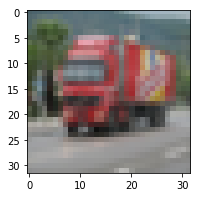

In [55]:
import matplotlib.pyplot as plt

%matplotlib inline

## The original image
idx = np.random.choice(range(len(x_test)), 1)[0]
img = x_test[idx]

fig = plt.figure(figsize=(3, 3))
plt.imshow(img)

## The extened image
img_datagen = ImageDataGenerator(rescale=1./255
                                 ,preprocessing_function = preprocessing_fun)
training_gen = img_datagen.flow_from_directory(PATH, target_size=(224,224)
                                               ,color_mode='rgb',batch_size=32, shuffle=False)

In [34]:
idx

array([9396])

## 모델 훈련

In [63]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data = (x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2002s 40ms/step - loss: 2.3032 - acc: 0.0966 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/10
31200/50000 [=================>............] - ETA: 12:13 - loss: 2.3026 - acc: 0.0999

In [29]:
model.layers[-1].get_weights()

[]

## 모델 평가

In [ ]:
model.evaluate(x_test, y_test, batch_size=1000)

In [31]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

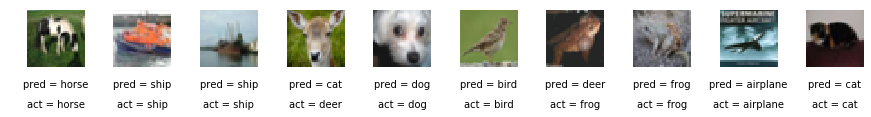

In [32]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, idx in enumerate(indices):)
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)